In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('font', size=16)

# Adsorption model $\mathbf{m}(\mathbf{p})$

In [2]:
# Langmuir params for MOF 2
K2 = [0.1, 0.5]
M2 = 1.0
# Langmuir params for MOF 1
K1 = [0.7, 0.3]
M1 = 2.0

# f is the forward function
def f_1(p):
    return M1 * np.dot(K1, p) / (1 + np.dot(K1, p))

def f_2(p):
    return M2 * np.dot(K2, p) / (1 + np.dot(K2, p))

def f(p): #p is a vector
    return [f_1(p), f_2(p)]

# Inverse of adsorption model $\mathbf{p}(\mathbf{m})$

In [6]:
# g is the inverse function
def g(m_0, p_lb, p_ub): 
    #  we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f_want_0(p):
        return f(p) - m_0
    sol = optimize.root(f_want_0, [1.0, 1.0])
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
    if p[0] < p_lb or p[1] < p_lb or p[0] > p_ub or p[1] > p_ub:
        return np.array([np.nan, np.nan])
    if not sol.success:
        return np.array([np.nan, np.nan])
#     assert np.all(np.isclose([f_1(p), f_2(p)], m_0))
    return p


In [7]:
g(np.array([.6,.2]), 0, np.Inf)

array([0.43526786, 0.41294643])

# Bivariate Color Map

In [5]:
def colorFromBivariateData(x,y,cmap1 = plt.cm.Greens, cmap2 = plt.cm.YlOrRd):
    if np.any(x > 1) or np.any(y > 1):
        raise Exception("Numbers must be between 0 and 1.")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        return np.array([1, 1, 1, 1])
    x_color = cmap1(x)
    y_color = cmap2(y)

    # Color for each point
    xy_color = np.sum([x_color, y_color], axis=0)/2.0

    return xy_color

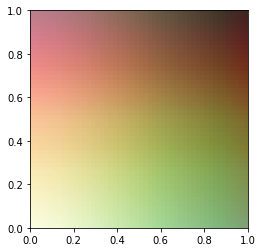

In [6]:
# Example of colorFromBivariateData function
x = np.linspace(0, 1)
y = np.linspace(0, 1)
z = [[colorFromBivariateData(x[i], y[j]) for i in range(np.size(x))] for j in range(np.size(y))]
extent = (0, 1, 0, 1) #figure out how to put our desired x/y lims on this
plt.imshow(z, extent=extent, origin='lower')

# Functions to draw grid lines

In [7]:
# function to draw vertial grid line on plot
def draw_vert_line(x, y_min, y_max, plt_num):
    ax[plt_num].plot([x, x], [y_min, y_max], color="black", lw=3)  

# function to draw horizontal grid line on plot
def draw_horizontal_line(y, x_min, x_max, plt_num):
    ax[plt_num].plot([x_min, x_max], [y, y], color="black", lw=3) 

# Functions to determine valid ranges of m1, m2

In [8]:
#### Functions to get valid m values to draw vertical grid lines ####
def find_pa_vert(m1): #find pa given that f_1([pa,0]) = m1
    return m1 / ((M1 - m1) * K1[0])

def find_pb_vert(m1): #find pb given that f_1([0, pb]) = m1
    return m1 / ((M1 - m1) * K1[1])

def find_pa_vert_pmax(m1): #find pa given that f_1([pa,p_max]) = m1
    return (m1 + m1*K1[1]*p_max - M1*K1[1]*p_max) / ((M1 - m1) * K1[0])

def find_pb_vert_pmax(m1): #find pb given that f_1([p_max, pb]) = m1
    return (m1 + m1*K1[0]*p_max - M1*K1[0]*p_max) / ((M1 - m1) * K1[1])

def valid_m2(m1): #find valid m2 value range for m1 
    pa = find_pa_vert(m1)
    pb = find_pb_vert(m1)   
    if pb > p_max and pa < p_max:
        m2_min = f_2([pa, 0])
        m2_max = f_2([find_pa_vert_pmax(m1), p_max])
    elif pb > p_max and pa > p_max:
        m2_min = f_2([p_max, find_pb_vert_pmax(m1)])
        m2_max = f_2([find_pa_vert_pmax(m1), p_max])
    else:
        m2_min = f_2([pa, 0])
        m2_max = f_2([0, pb])    
    return m2_min, m2_max

In [9]:
#### Functions to get valid m values to draw horizontal grid lines ####
def find_pa_horizontal(m2): #find pa given that f_1([pa,0]) = m2
    return m2 / ((M2 - m2) * K2[0])

def find_pb_horizontal(m2): #find pb given that f_1([0, pb]) = m2
    return m2 / ((M2 - m2) * K2[1])

def find_pa_horizontal_pmax(m2): #find pa given that f_1([pa,p_max]) = m2
    return (m2 + m2*K2[1]*p_max - M2*K2[1]*p_max) / ((M2 - m2) * K2[0])

def find_pb_horizontal_pmax(m2): #find pb given that f_1([p_max, pb]) = m2
    return (m2 + m2*K2[0]*p_max - M2*K2[0]*p_max) / ((M2 - m2) * K2[1])

def valid_m1(m2): #find valid m1 value range for m2 
    pa = find_pa_horizontal(m2)
    pb = find_pb_horizontal(m2)   
    if pa > p_max and pb < p_max:
        m1_min = f_1([0, pb])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    elif pa > p_max and pb > p_max:
        m1_min = f_1([find_pa_horizontal_pmax(m2), p_max])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    else:
        m1_min = f_1([0, pb])
        m1_max = f_1([pa, 0])    
    return m1_min, m1_max

# Function to draw boundary on response space

In [10]:
# Function to draw boundary around response space figure
def draw_mspace_boundaries(p_max, plt_num):
    x = np.linspace(0, p_max) 
    m1 = np.zeros(len(x))
    m2 = np.zeros(len(x))
    for i in range(len(x)):
        # make pa = 0
        p = [0, x[i]]
        m1[i] = f_1(p) 
        m2[i] = f_2(p)
    ax[plt_num].plot(m1,m2, color="black", lw=3)
    for i in range(len(x)):        
        # make pb = 0
        p = [x[i], 0]
        m1[i] = f_1(p) 
        m2[i] = f_2(p)
    ax[plt_num].plot(m1,m2,color="black", lw=3)
    for i in range(len(x)):        
        # make pa = max
        p = [p_max, x[i]]
        m1[i] = f_1(p) 
        m2[i] = f_2(p)
    ax[plt_num].plot(m1,m2,color="black", lw=3)
    for i in range(len(x)):        
        # make pb = max
        p = [x[i], p_max]
        m1[i] = f_1(p) 
        m2[i] = f_2(p)
    ax[plt_num].plot(m1,m2,color="black", lw=3)

# Mapping Composition Space to Response Space

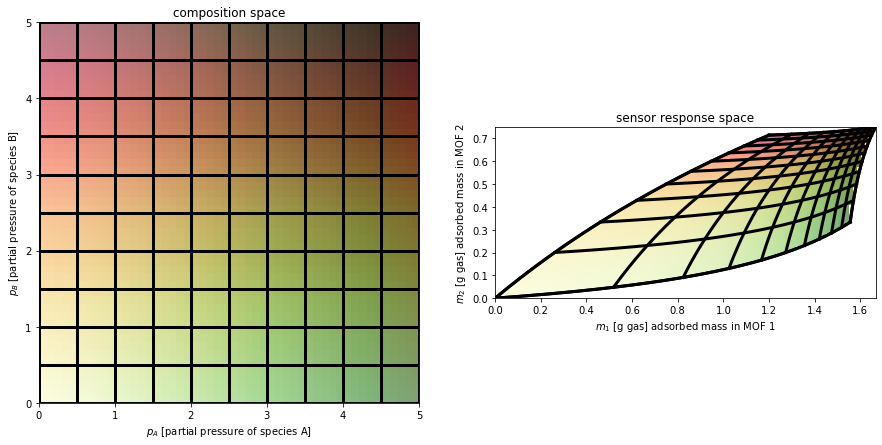

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
###
#   composition space
###
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
p_max = 5.0 # largest pressure we go to.
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    
    # plot the line in composition space
    draw_vert_line(p_a, 0, p_max, 0)
    
    # plot the image of the line in sensor response space
    p_b = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a, p_b[j]])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = f_1(p_on_line)
        m2[j] = f_2(p_on_line)
    ax[1].plot(m1, m2, color="black", lw=3)
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
 
    # plot the line in composition space
    draw_horizontal_line(p_b, 0, p_max, 0)
    
    # plot the image of the line in sensor response space
    p_a = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = np.array([p_a[j], p_b])
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = f_1(p_on_line)
        m2[j] = f_2(p_on_line)
    ax[1].plot(m1, m2, color="black", lw=3)
        
###
#   color the plane
###
# Initialize pa, pb for colormap
pa = np.linspace(0, p_max)
pb = np.linspace(0, p_max)

# Create bivariate colormap for composition space
z_composition = [[colorFromBivariateData(pa[i]/p_max, pb[j]/p_max) for i in range(np.size(pa))] for j in range(np.size(pb))]

# find maximum mass
m_max = [f_1([p_max,p_max]), f_2([p_max,p_max])]

# Initialize m1, m2 for colormap
num_grid_pts = 100
m1_grid = np.linspace(0, m_max[0], num_grid_pts)
m2_grid = np.linspace(0, m_max[1], num_grid_pts)

# Initialize response space colormap, 
z_response = [[colorFromBivariateData(0, 0) for i in range(num_grid_pts)] for j in range(num_grid_pts)]

# Modify bivariate colormap for response space based on mapping from composition space 
for i in range(num_grid_pts):
    for j in range(num_grid_pts):
        m_0 = [m1_grid[i], m2_grid[j]]
        p = g(m_0, 0, p_max) 
        z_response[j][i] = colorFromBivariateData(p[0]/p_max, p[1]/p_max)

# Create extent of colormaps
extent_composition = (0, p_max, 0, p_max) 
extent_response = (0, m_max[0], 0, m_max[1])

# Plot colormaps in composition and response space
ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        
ax[1].imshow(z_response, extent=extent_response,  origin='lower') 
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

# Add boarder around response space
draw_mspace_boundaries(p_max, 1)

# Testing to ensure points map to correct response space
# p = [0,5]
# m = [f_1(p), f_2(p)]
# print("m :", m)
# ax[0].scatter([p[0]],[p[1]], color='red', s=70)
# ax[1].scatter([m[0]],[m[1]], color='red', s=70)

# Mapping Response Space to Composition Space

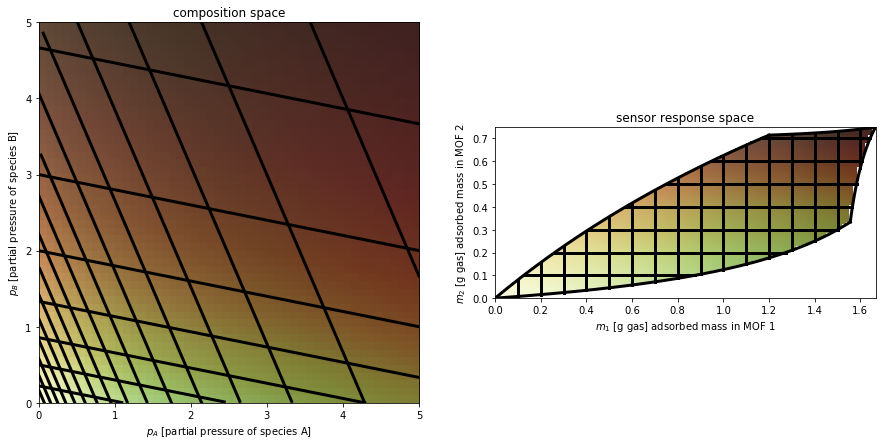

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
###
#   composition space
###
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")
# set composition space to exclude negative pressures 
ax[0].set_xlim(xmin=0, xmax=p_max)
ax[0].set_ylim(ymin=0, ymax=p_max)

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   color the plane
###
nb_pts = 100
# Initialize m1, m2 for colormap
m1 = np.linspace(0, m_max[0], nb_pts)
m2 = np.linspace(0, m_max[1], nb_pts)

# Create bivariate colormap for response space
z_response = [[colorFromBivariateData(m1[i]/m_max[0], m2[j]/m_max[1]) for i in range(np.size(m1))] 
                 for j in range(np.size(m2))]

# Modify response space colormap to only have color where presssure is positive
for i in range(np.shape(z_response)[0]):
    for j in range(np.shape(z_response)[1]):
        m_0 = [m1[i], m2[j]]
        p = g(m_0, 0, np.Inf) 
        # zero out (i.e. set color to white) responses that correspond to negative pressures
        if np.any(np.isnan(p)) or np.any(p > p_max):
            z_response[j][i] = np.array([1, 1, 1, 1])
            
# Plot colormap on response space 
ax[1].imshow(z_response, extent=extent_response,  origin='lower')           
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')    
    
# Create bivariate colormap for composition space based on mapping from response space 
for i in range(np.shape(z_composition)[0]):
    for j in range(np.shape(z_composition)[1]):
        p_0 = np.array([pa[i], pb[j]])
        m = np.array([f_1(p_0), f_2(p_0)])
        # zero out responses that are above m_max
        if np.any(m > m_max):
            z_composition[j][i] = np.array([1, 1, 1, 1])
        else:
            z_composition[j][i] = colorFromBivariateData(m[0]/m_max[0], m[1]/m_max[1])   

# Plot colormap on composition space
ax[0].imshow(z_composition, extent=extent_composition, origin='lower')        

###
#   draw grid lines and their mapping
###
dm = 0.1 # spacing between grid lines
nb_pts = 100
# these arrays will contain the correponding compositions to each point on the lines.
p_a = np.zeros(nb_pts)
p_b = np.zeros(nb_pts)


for i in range(int(max(m_max) / dm)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    m1 = i * dm # m1 is constant here.

    if m1 < m_max[0]:
        m2_min, m2_max = valid_m2(m1)
        draw_vert_line(m1, m2_min, m2_max, 1)
    
        # plot the image of the line in composition space
        m2 = np.linspace(m2_min, m2_max, nb_pts)

        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1, m2[j]])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = g(m_on_line, 0, np.Inf) 
        ax[0].plot(p_a, p_b, color="black", lw=3)

    ###
    #   y = constant (horizontal) grid lines
    ###
    m2 = i * dm # m2 is constant here.

    if m2 < m_max[1]:
        m1_min, m1_max = valid_m1(m2)
        draw_horizontal_line(m2, m1_min, m1_max, 1)
        
        # plot the image of the line in composition space
        m1 = np.linspace(m1_min, m1_max, nb_pts)
    
        # loop through points on the line
        for j in range(nb_pts):
            # get vector on this line
            m_on_line = np.array([m1[j], m2])
            # compute the composition in the gas space when MOFs have this much gas absorbed
            p_a[j], p_b[j] = g(m_on_line, 0, np.Inf) 
        ax[0].plot(p_a, p_b, color="black", lw=3)
        
# Add boarder around response space
draw_mspace_boundaries(p_max, 1) 

# Visualizing m_1(p) and m_2(p) in 3D

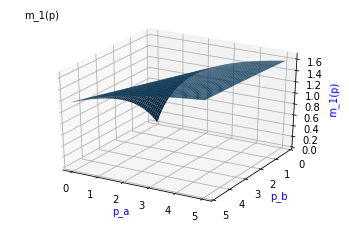

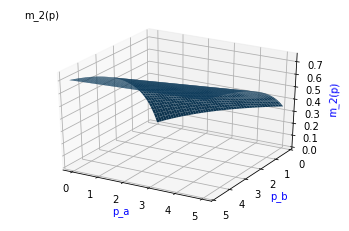

In [13]:
#%matplotlib notebook
nb_pts = 100

# Create 2D linspace from 0 to p_max
p_a = np.outer(np.linspace(0, p_max, nb_pts), np.ones(nb_pts))
p_b = p_a.copy().T # transpose

# Create empty 2D array that is the same shape as p_a and p_b
m1 = np.zeros((np.shape(p_a)[0], np.shape(p_a)[1]))
m2 = np.zeros((np.shape(p_a)[0], np.shape(p_a)[1]))

# Compute m_1(p), m_2(p) for each pair of pressures
for i in range(np.shape(p_a)[0]):
    for j in range(np.shape(p_b)[0]):
        p = [p_a[i][j], p_b[i][j]]
        m1[i][j] = np.array(f_1(p))
        m2[i][j] = np.array(f_2(p))

# 3D plot for m_1(p)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(p_a, p_b, m1)
ax.text2D(0.05, 0.95, "m_1(p)", transform=ax.transAxes)
ax.set_xlabel('p_a', color='blue')
ax.set_ylabel('p_b', color='blue')
ax.set_zlabel('m_1(p)', color='blue')
ax.set_ylim(5,0)
ax.dist = 11

# 3D plot for m_2(p)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(p_a, p_b, m2)
ax.text2D(0.05, 0.95, "m_2(p)", transform=ax.transAxes)
ax.set_xlabel('p_a', color='blue')
ax.set_ylabel('p_b', color='blue')
ax.set_zlabel('m_2(p)', color='blue')
ax.set_ylim(5,0)
ax.dist = 11

# plot $\kappa$ for inverse problem on the m- and p-planes

In [13]:
K1 = [1,2]
K2 = [3,4]
M1 = 1
M2 = 2
pa = 1
pb = 2


# inverse
def κ(p):
    J_f = np.array([ [M1*K1[0]/(1 + np.dot(K1, p))**2, M1*K1[1]/(1 + np.dot(K1, p))**2],
       [M2*K2[0]/(1 + np.dot(K2, p))**2, M2*K2[1]/(1 + np.dot(K2, p))**2]])
    J_g = np.linalg.inv(J_f)
    m = f(p)
    #g_inv = g(m, 0, np.Inf)
    return (  np.linalg.norm(m) / np.linalg.norm(p)) * np.linalg.norm(J_g, ord=2) 

print(κ(np.array([0.6, 0.2])))
#g([0.6, 0.2], 0, np.Inf)

29.73565226947696
